# Quickstart с langgraph.js
**Это переведенный ноутбук. Прочитать оригинал и больше документов по LangGraph.js можно [здесь](https://langchain-ai.github.io/langgraphjs/tutorials/quickstart/) **

## Интро
В этом руководстве по быстрому запуску вы научитесь работать с простым Reason + Act Agent (часто называемым ReAct Agent), который может выполнять поиск в интернете с помощью [Tavily Search API](https://tavily.com/). 

Код полностью настраиваемый. Вы можете:  
- заменять компоненты
- настраивать последовательность выполнения
- расширять функциональность с помощью пользовательского кода или инструментов
- изменять используемую большую языковую модель (LLM) и ее провайдера

## Предварительные условия

Для запуска данного руководства вам потребуется:

- NodeJS версии 18 или новее  
- Учетная запись [Tavily](https://tavily.com/) и API-ключ  
- Учетная запись на платформе [developers.sber.ru](https://developers.sber.ru/) и подключенный к аккаунту GigaChat

Начните с создания новой папки для проекта. Откройте терминал и выполните следующие команды:

```bash
mkdir langgraph-agent
cd langgraph-agent
```

Также потребуется установить несколько зависимостей для создания агента:

- **@langchain/core**: содержит основные строительные блоки для сборки агента.  
- **@langchain/langgraph**: предоставляет возможности интеграции с LangGraph.  
- **langchain-gigachat**: позволяет вашему агенту использовать GigaChat LLM.  
- **@langchain/community**: включает интеграцию Tavily для предоставления возможностей поиска.  

Установите эти зависимости, выполнив следующую команду npm в терминале:

```bash
npm install @langchain/core @langchain/langgraph langchain-gigachat @langchain/community
```

## Создание первого агента с использованием LangGraph
Создайте файл с именем `agent.ts` (сокращение от Reason + Act Agent) и добавьте в него приведенный ниже код на TypeScript.

Убедитесь, что вы обновили переменные окружения в начале файла, указав ваши API-ключи. Если этого не сделать, вызовы API GigaChat и Tavily приведут к ошибкам, и ваш агент не будет работать корректно.

После добавления API-ключей сохраните файл и выполните код с помощью следующей команды:
```bash
npx tsx agent.ts
```

In [4]:
// agent.ts

// IMPORTANT - Добавить API ключи для подключение к сервиса
// process.env.GIGACHAT_CREDENTIALS = "...";
// process.env.GIGACHAT_SCOPE = "...";
// process.env.TAVILY_API_KEY = "tvly-...";

import { TavilySearchResults } from "@langchain/community/tools/tavily_search";
import { GigaChat } from "langchain-gigachat";
import { HumanMessage } from "@langchain/core/messages";
import { ToolNode } from "@langchain/langgraph/prebuilt";
import { StateGraph, MessagesAnnotation } from "@langchain/langgraph";

// Определим функции, которые будет использовать агент
const tools = [new TavilySearchResults({ maxResults: 3 })];
const toolNode = new ToolNode(tools);

/*
В обычном Node.js такое отключение проверки сертификатов срабатывает.

Но в Deno нет, 
поэтому используйте проставление NODE_EXTRA_CA_CERTS в env.
 */
const httpsAgent = new Agent({
  rejectUnauthorized: false,
}); 

// Создадим подключение к GigaChat и привяжем функции 
const model = new GigaChat({
  model: "GigaChat-Max",
  temperature: 0.1,
  httpsAgent
}).bindTools(tools, {tool_choice: 'auto'});

// Определим функцию, которая решает стоит ли агенту продолжать свое выполенение
function shouldContinue({ messages }: typeof MessagesAnnotation.State) {
  const lastMessage = messages[messages.length - 1];

   // Если LLM вызывает инструмент, мы перенаправляем запрос в узел "tools".
  if (lastMessage.additional_kwargs.tool_calls) {
    return "tools";
  }
  // В противном случае мы останавливаемся (отвечаем пользователю) с помощью специального узла "__end__".
  return "__end__";
}

// Определите функцию, которая вызывает модель.
async function callModel(state: typeof MessagesAnnotation.State) {
  const response = await model.invoke(state.messages);

  // Мы возвращаем список, так как он будет добавлен к уже существующему списку.
  return { messages: [response] };
}

// Определяем граф
const workflow = new StateGraph(MessagesAnnotation)
  .addNode("agent", callModel)
  .addEdge("__start__", "agent") // __start__ — это специальное имя для точки входа.
  .addNode("tools", toolNode)
  .addEdge("tools", "agent")
  .addConditionalEdges("agent", shouldContinue);

// В заключение мы компилируем это в LangChain Runnable.
const app = workflow.compile();

// Запускаем агента
const finalState = await app.invoke({
  messages: [new HumanMessage("Какая погода в Москве узнай с помощью Tavily?")],
});
console.log(finalState.messages[finalState.messages.length - 1].content);

const nextState = await app.invoke({
  // Включение сообщений из предыдущего запуска дает LLM контекст.
  // Таким образом, модель понимает, что мы спрашиваем о погоде в Питере.
  messages: [...finalState.messages, new HumanMessage("А что насчет Питера?")],
});
console.log(nextState.messages[nextState.messages.length - 1].content);

UPDATE TOKEN
Сейчас в Москве облачно, температура воздуха -2°C, относительная влажность воздуха 83%, атмосферное давление 753 мм рт. ст., ветер северо-западный 1 м/с.
Согласно данным AccuWeather, в Санкт-Петербурге сейчас облачно, температура воздуха около 0°C, ощущается как -3°C. Ветер южный, скорость около 18 км/ч. Относительная влажность воздуха составляет 76%.


# Визуализация агента
Давайте посмотрим схему нашего графа.
**Важно**: Мы запускаем этот ноутбук с помощью Deno

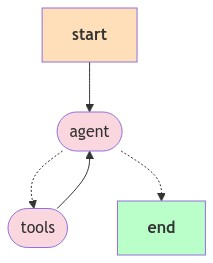

In [ ]:
const graph = app.getGraph();
const image = await graph.drawMermaidPng();
const arrayBuffer = await image.arrayBuffer();

new Uint8Array(arrayBuffer)